# GARF (Genetic Algorithm Random Forest) for MIMIC-III Dataset

This notebook implements a genetic algorithm approach to optimize Random Forest hyperparameters for prediction tasks on the MIMIC-III dataset. GARF combines genetic algorithms with random forests to find optimal hyperparameter configurations.

In [9]:
# Import required libraries
import pandas as pd
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import time
from datetime import datetime
import os
import pickle

# Import local modules
import sys
sys.path.append('..')
from analysis.mimic_extract import extract
from califorest import metrics as em
from califorest import (
    CaliForest,
    RC30,
    ImprovedCaliForest,
    VennAbersForest,
    ImprovedVennAbersForest
)

## 1. Setting up the GARF Algorithm

First, we'll define the genetic algorithm parameters and functions for the MIMIC-III dataset.

In [14]:
# Configuration for the genetic algorithm
class GARFConfig:
    def __init__(self):
        # GA parameters
        self.generations = 10           # Number of generations to run
        self.population_size = 15       # Population size in each generation
        self.chromosome_length = 13     # Total bits in chromosome
        self.crossover_rate = 0.5       # Probability of crossover
        self.mutation_rate = 0.02       # Probability of mutation
        
        # Hyperparameter encoding information
        # n_estimators: 50-500 in steps of 50 (4 bits: 0-15 -> 50-800)
        self.n_estimators_bits = 4
        # max_depth: 5-20 (4 bits: 0-15 -> 5-20)
        self.max_depth_bits = 4
        # min_samples_split: 2-10 (3 bits: 0-7 -> 2-9)
        self.min_samples_split_bits = 3
        # max_features: options (2 bits: 0-3 -> 'sqrt', 'log2', 0.3, 0.5)
        self.max_features_bits = 2
        
        # List to store results
        self.avg_scores = []
        self.max_scores = []
        self.best_models = []
        
        # Create output directory
        os.makedirs("garf_results", exist_ok=True)

# Initialize configuration
config = GARFConfig()

## 2. GARF Utility Functions

Let's implement the genetic algorithm functions needed to evolve our population.

In [15]:
# Initialize a random population
def initialize_population(pop_size, chrom_len):
    population = []
    for i in range(pop_size):
        # Generate a random chromosome as a binary string
        chromosome = [random.randint(0, 1) for _ in range(chrom_len)]
        population.append(chromosome)
    return population

# Decode chromosomes into actual hyperparameter values
def decode_chromosomes(population, config):
    decoded_params = []
    
    for chromosome in population:
        params = {}
        
        # Extract and decode n_estimators (4 bits)
        n_est_bits = chromosome[0:config.n_estimators_bits]
        n_est_value = 0
        for i in range(len(n_est_bits)):
            n_est_value += n_est_bits[i] * (2 ** i)
        params['n_estimators'] = (n_est_value + 1) * 50  # 50-800
        
        # Extract and decode max_depth (4 bits)
        start_idx = config.n_estimators_bits
        max_depth_bits = chromosome[start_idx:start_idx + config.max_depth_bits]
        max_depth_value = 0
        for i in range(len(max_depth_bits)):
            max_depth_value += max_depth_bits[i] * (2 ** i)
        params['max_depth'] = max_depth_value + 5  # 5-20
        
        # Extract and decode min_samples_split (3 bits)
        start_idx += config.max_depth_bits
        mss_bits = chromosome[start_idx:start_idx + config.min_samples_split_bits]
        mss_value = 0
        for i in range(len(mss_bits)):
            mss_value += mss_bits[i] * (2 ** i)
        params['min_samples_split'] = mss_value + 2  # 2-9
        
        # Extract and decode max_features (2 bits)
        start_idx += config.min_samples_split_bits
        mf_bits = chromosome[start_idx:start_idx + config.max_features_bits]
        mf_value = 0
        for i in range(len(mf_bits)):
            mf_value += mf_bits[i] * (2 ** i)
        
        # Map to max_features options
        max_features_options = ['sqrt', 'log2', 0.3, 0.5]
        params['max_features'] = max_features_options[min(mf_value, len(max_features_options)-1)]
        
        decoded_params.append(params)
    
    return decoded_params

# Evaluate hyperparameter fitness using Random Forest on MIMIC data
def evaluate_fitness(params, X_train, y_train, X_test, y_test):
    # Create and train the model
    model = RandomForestClassifier(
        n_estimators=params['n_estimators'],
        max_depth=params['max_depth'],
        min_samples_split=params['min_samples_split'],
        max_features=params['max_features'],
        n_jobs=-1,
        random_state=42
    )
    
    # Time the training
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    # Make predictions
    y_pred = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    auc = roc_auc_score(y_test, y_pred)
    brier, brier_scaled = em.scaled_brier_score(y_test, y_pred)
    hl_pvalue = em.hosmer_lemeshow(y_test, y_pred)
    
    # Normalize brier score to be higher-is-better
    normalized_brier = 1 - min(brier, 0.25) * 4
    
    # Fitness score (multi-objective: discrimination + calibration)
    fitness = 0.6 * auc + 0.3 * normalized_brier + 0.1 * min(1.0, hl_pvalue)
    
    # Return fitness and details for logging
    return fitness, {
        'n_estimators': params['n_estimators'],
        'max_depth': params['max_depth'],
        'min_samples_split': params['min_samples_split'],
        'max_features': params['max_features'],
        'auc': auc,
        'brier': brier,
        'brier_scaled': brier_scaled,
        'hl_pvalue': hl_pvalue,
        'train_time': train_time
    }

# Evaluate the entire population
def evaluate_population(population, decoded_params, X_train, y_train, X_test, y_test):
    fitness_values = []
    fitness_details = []
    
    for i, params in enumerate(decoded_params):
        fitness, details = evaluate_fitness(params, X_train, y_train, X_test, y_test)
        fitness_values.append(fitness)
        fitness_details.append(details)
        print(f"Individual {i+1}/{len(population)}: fitness={fitness:.4f}, auc={details['auc']:.4f}, brier={details['brier']:.4f}")
    
    return fitness_values, fitness_details

# Selection operation (tournament selection)
def selection(population, fitness_values, tournament_size=3):
    new_population = []
    
    for _ in range(len(population)):
        # Select random candidates for tournament
        tournament_indices = random.sample(range(len(population)), tournament_size)
        tournament_fitness = [fitness_values[i] for i in tournament_indices]
        
        # Select winner (highest fitness)
        winner_idx = tournament_indices[tournament_fitness.index(max(tournament_fitness))]
        new_population.append(population[winner_idx].copy())
    
    return new_population

# Crossover operation (single-point crossover)
def crossover(population, crossover_rate):
    new_population = []
    
    # Process pairs of chromosomes
    for i in range(0, len(population), 2):
        parent1 = population[i]
        
        # Handle the case where population size is odd
        if i + 1 < len(population):
            parent2 = population[i + 1]
            
            # Apply crossover with probability crossover_rate
            if random.random() < crossover_rate:
                # Choose random crossover point
                crossover_point = random.randint(1, len(parent1) - 1)
                
                # Create children by swapping segments
                child1 = parent1[:crossover_point] + parent2[crossover_point:]
                child2 = parent2[:crossover_point] + parent1[crossover_point:]
                
                new_population.extend([child1, child2])
            else:
                # No crossover, keep parents
                new_population.extend([parent1, parent2])
        else:
            # If odd population size, keep the last parent
            new_population.append(parent1)
    
    return new_population

# Mutation operation (bit-flip mutation)
def mutation(population, mutation_rate):
    for i in range(len(population)):
        for j in range(len(population[i])):
            if random.random() < mutation_rate:
                # Flip the bit (0->1 or 1->0)
                population[i][j] = 1 - population[i][j]
    
    return population

## 3. GARF for MIMIC-III Implementation

Now let's implement the main GARF algorithm for MIMIC-III data.

In [16]:
def run_garf(target, random_seed=42, mimic_size="1000_subjects"):
    """
    Run GARF optimization on MIMIC-III data for the specified prediction task.
    
    Parameters:
    - target: str, the prediction target ('mort_hosp', 'mort_icu', 'los_3', 'los_7')
    - random_seed: int, random seed for reproducibility
    - mimic_size: str, the size of the MIMIC dataset to use
    
    Returns:
    - best_config: dict, the best hyperparameter configuration found
    """
    # Set random seed for reproducibility
    random.seed(random_seed)
    np.random.seed(random_seed)
    
    # Load MIMIC-III data
    print(f"Loading MIMIC-III data for {target} prediction task...")
    X_train, X_test, y_train, y_test = extract(random_seed, target, mimic_size)
    print(f"Data loaded. X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"Class distribution in training set: {np.bincount(y_train)}")
    
    # Initialize population
    print("Initializing population...")
    population = initialize_population(config.population_size, config.chromosome_length)
    
    # For storing results
    avg_fitness_history = []
    best_fitness_history = []
    best_individual = None
    best_fitness = 0
    best_details = None
    
    # Run the genetic algorithm
    start_time = time.time()
    print(f"Starting genetic algorithm optimization with {config.generations} generations...")
    
    for generation in range(config.generations):
        gen_start_time = time.time()
        print(f"\nGeneration {generation+1}/{config.generations}")
        
        # Decode chromosomes to hyperparameters
        decoded_params = decode_chromosomes(population, config)
        
        # Evaluate fitness
        fitness_values, fitness_details = evaluate_population(
            population, decoded_params, X_train, y_train, X_test, y_test
        )
        
        # Track statistics
        avg_fitness = np.mean(fitness_values)
        avg_fitness_history.append(avg_fitness)
        
        # Find the best individual in this generation
        gen_best_idx = np.argmax(fitness_values)
        gen_best_fitness = fitness_values[gen_best_idx]
        gen_best_individual = population[gen_best_idx]
        gen_best_details = fitness_details[gen_best_idx]
        best_fitness_history.append(gen_best_fitness)
        
        # Update overall best if improved
        if gen_best_fitness > best_fitness:
            best_fitness = gen_best_fitness
            best_individual = gen_best_individual.copy()
            best_details = gen_best_details
        
        # Print generation summary
        print(f"Generation {generation+1} summary:")
        print(f"  Average fitness: {avg_fitness:.4f}")
        print(f"  Best fitness: {gen_best_fitness:.4f}")
        print(f"  Best configuration: n_estimators={gen_best_details['n_estimators']}, "
              f"max_depth={gen_best_details['max_depth']}, "
              f"min_samples_split={gen_best_details['min_samples_split']}, "
              f"max_features={gen_best_details['max_features']}")
        print(f"  Performance: AUC={gen_best_details['auc']:.4f}, "
              f"Brier={gen_best_details['brier']:.4f}, "
              f"HL p-value={gen_best_details['hl_pvalue']:.4f}")
        
        # Early stopping condition (optional)
        if gen_best_fitness >= 0.98:  # Near-perfect fitness
            print("Early stopping: Near-perfect solution found.")
            break
        
        # Apply genetic operations (if not the last generation)
        if generation < config.generations - 1:
            # Selection
            population = selection(population, fitness_values)
            
            # Crossover
            population = crossover(population, config.crossover_rate)
            
            # Mutation
            population = mutation(population, config.mutation_rate)
        
        gen_time = time.time() - gen_start_time
        print(f"Generation completed in {gen_time:.2f} seconds")
    
    total_time = time.time() - start_time
    print(f"\nGARF optimization completed in {total_time:.2f} seconds")
    
    # Print final best solution
    print("\nBest hyperparameter configuration:")
    print(f"  n_estimators: {best_details['n_estimators']}")
    print(f"  max_depth: {best_details['max_depth']}")
    print(f"  min_samples_split: {best_details['min_samples_split']}")
    print(f"  max_features: {best_details['max_features']}")
    print(f"\nPerformance:")
    print(f"  AUC: {best_details['auc']:.4f}")
    print(f"  Brier Score: {best_details['brier']:.4f}")
    print(f"  Scaled Brier Score: {best_details['brier_scaled']:.4f}")
    print(f"  Hosmer-Lemeshow p-value: {best_details['hl_pvalue']:.4f}")
    
    # Save results
    results = {
        'target': target,
        'mimic_size': mimic_size,
        'seed': random_seed,
        'generations': config.generations,
        'population_size': config.population_size,
        'best_fitness': best_fitness,
        'best_individual': best_individual,
        'best_details': best_details,
        'fitness_history': {
            'avg_fitness': avg_fitness_history,
            'best_fitness': best_fitness_history
        },
        'runtime': total_time
    }
    
    # Save to file
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    result_file = f"garf_results/{target}_{mimic_size}_{timestamp}.pkl"
    with open(result_file, 'wb') as f:
        pickle.dump(results, f)
    
    # Plot fitness history
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(avg_fitness_history) + 1), avg_fitness_history, 'b-', label='Average Fitness')
    plt.plot(range(1, len(best_fitness_history) + 1), best_fitness_history, 'r-', label='Best Fitness')
    plt.xlabel('Generation')
    plt.ylabel('Fitness Score')
    plt.title(f'GARF Fitness Progression for {target} Prediction')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"garf_results/{target}_{mimic_size}_{timestamp}_fitness.png")
    plt.show()
    
    return best_details

## 4. Run GARF for a MIMIC-III Prediction Task

Let's run the GARF optimization for hospital mortality prediction.

Loading MIMIC-III data for mort_hosp prediction task...


/Users/pranavherur/Documents/side_projects/califorest/analysis/../analysis/mimic_extract.py:24: FutureWarning: DataFrameGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use DataFrame.fillna instead
  df_out.loc[:, idx[:, "mean"]]
/Users/pranavherur/Documents/side_projects/califorest/analysis/../analysis/mimic_extract.py:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_out.loc[:, idx[:, "mean"]]
/Users/pranavherur/Documents/side_projects/califorest/analysis/../analysis/mimic_extract.py:28: FutureWarning: DataFrameGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use DataFrame.fillna instead
  .fillna(icustay_means)
/Users/pranavhe

Data loaded. X_train shape: (3500, 7488), y_train shape: (3500,)
Class distribution in training set: [3132  368]
Initializing population...
Starting genetic algorithm optimization with 5 generations...

Generation 1/5
Individual 1/5: fitness=0.7436, auc=0.8898, brier=0.0753
Individual 2/5: fitness=0.7284, auc=0.8692, brier=0.0776
Individual 3/5: fitness=0.7433, auc=0.8783, brier=0.0701
Individual 4/5: fitness=0.7524, auc=0.8918, brier=0.0691
Individual 5/5: fitness=0.7566, auc=0.8990, brier=0.0690
Generation 1 summary:
  Average fitness: 0.7449
  Best fitness: 0.7566
  Best configuration: n_estimators=600, max_depth=10, min_samples_split=2, max_features=0.5
  Performance: AUC=0.8990, Brier=0.0690, HL p-value=0.0000
Generation completed in 259.64 seconds

Generation 2/5
Individual 1/5: fitness=0.7566, auc=0.8990, brier=0.0690
Individual 2/5: fitness=0.7560, auc=0.8970, brier=0.0685
Individual 3/5: fitness=0.7487, auc=0.8909, brier=0.0716
Individual 4/5: fitness=0.7421, auc=0.8819, brier

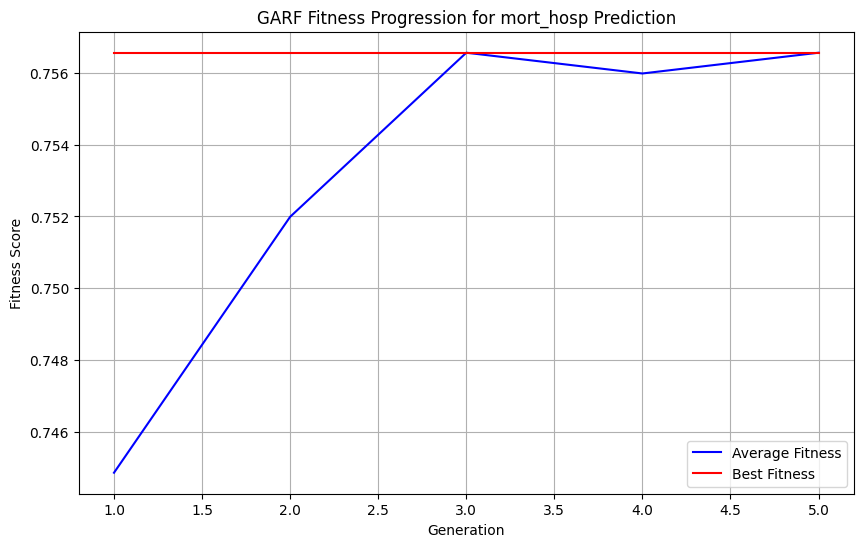

In [17]:
# Run GARF for hospital mortality prediction
best_config = run_garf('mort_hosp', random_seed=42, mimic_size="5000_subjects")

## 5. Compare GARF with Other Models

Now let's compare our GARF-optimized model with other calibrated forest models.

In [7]:
def compare_models(target, best_config, random_seed=42, mimic_size="5000_subjects"):
    """
    Compare GARF-optimized model with other calibrated forest models.
    
    Parameters:
    - target: str, the prediction target
    - best_config: dict, the best configuration from GARF
    - random_seed: int, random seed for reproducibility
    - mimic_size: str, the size of the MIMIC dataset to use
    
    Returns:
    - results_df: pandas DataFrame with comparison results
    """
    # Load data
    print(f"Loading MIMIC-III data for {target} prediction task...")
    X_train, X_test, y_train, y_test = extract(random_seed, target, mimic_size)
    
    # Initialize models
    models = {
        "GARF-Optimized": RandomForestClassifier(
            n_estimators=best_config['n_estimators'],
            max_depth=best_config['max_depth'],
            min_samples_split=best_config['min_samples_split'],
            max_features=best_config['max_features'],
            n_jobs=-1,
            random_state=random_seed
        ),
        "CF-Iso": CaliForest(
            n_estimators=300,  # Default from test_improved_model.py
            max_depth=5,
            min_samples_split=3,
            min_samples_leaf=1,
            ctype="isotonic",
        ),
        "ImprovedCF-Iso": ImprovedCaliForest(
            n_estimators=300,
            max_depth=5,
            min_samples_split=3,
            min_samples_leaf=1,
            ctype="isotonic",
            ensemble_weight=0.7,
        ),
        "VennAbers-mean": VennAbersForest(
            n_estimators=300,
            max_depth=5,
            min_samples_split=3,
            min_samples_leaf=1,
            calibration_folds=5,
            average_method="mean",
        ),
        "RC-Iso": RC30(
            n_estimators=300,
            max_depth=5,
            min_samples_split=3,
            min_samples_leaf=1,
            ctype="isotonic",
        ),
        "RF-Default": RandomForestClassifier(
            n_estimators=300,
            max_depth=5,
            min_samples_split=3,
            min_samples_leaf=1,
            n_jobs=-1,
            random_state=random_seed
        ),
    }
    
    # Store results
    results = []
    
    # Test each model
    for name, model in models.items():
        print(f"Training {name}...")
        start_time = time.time()
        model.fit(X_train, y_train)
        train_time = time.time() - start_time
        
        y_pred = model.predict_proba(X_test)[:, 1]
        
        # Calculate metrics
        score_auc = roc_auc_score(y_test, y_pred)
        score_hl = em.hosmer_lemeshow(y_test, y_pred)
        score_sh = em.spiegelhalter(y_test, y_pred)
        score_b, score_bs = em.scaled_brier_score(y_test, y_pred)
        rel_small, rel_large = em.reliability(y_test, y_pred)
        
        # Store results
        results.append({
            'model': name,
            'target': target,
            'random_seed': random_seed,
            'auc': score_auc,
            'brier': score_b,
            'brier_scaled': score_bs,
            'hosmer_lemshow': score_hl,
            'speigelhalter': score_sh,
            'reliability_small': rel_small,
            'reliability_large': rel_large,
            'training_time': train_time
        })
        
        print(f"  AUC: {score_auc:.4f}, Brier: {score_b:.4f}, Train time: {train_time:.2f}s")
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    # Save results
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    results_df.to_csv(f"garf_results/{target}_comparison_{timestamp}.csv", index=False)
    
    # Plot comparison
    plt.figure(figsize=(15, 10))
    
    # Define metrics to plot
    metrics = [
        ('auc', 'AUC (higher is better)'),
        ('brier_scaled', 'Scaled Brier Score (higher is better)'),
        ('reliability_small', 'Reliability-in-the-small (lower is better)')
    ]
    
    for i, (metric, title) in enumerate(metrics):
        plt.subplot(1, 3, i+1)
        
        # For reliability_small, lower is better, so invert the color order
        if metric == 'reliability_small':
            # Sort by metric value ascending (lower is better)
            sorted_df = results_df.sort_values(by=metric)
            colors = sns.color_palette("YlOrRd_r", len(models))
        else:
            # Sort by metric value descending (higher is better)
            sorted_df = results_df.sort_values(by=metric, ascending=False)
            colors = sns.color_palette("YlGn", len(models))
        
        # Create bar plot
        ax = sns.barplot(x='model', y=metric, data=sorted_df, palette=colors)
        
        # Add value labels on bars
        for j, p in enumerate(ax.patches):
            ax.annotate(f"{p.get_height():.4f}",
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='bottom', fontsize=9, rotation=45)
        
        plt.title(title)
        plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    plt.savefig(f"garf_results/{target}_comparison_{timestamp}.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print summary table
    print("\nModel Comparison Summary:")
    summary_df = results_df[['model', 'auc', 'brier', 'brier_scaled', 'reliability_small']]
    display(summary_df.sort_values(by='auc', ascending=False))
    
    return results_df

In [8]:
# Compare GARF with other models
comparison_results = compare_models('mort_hosp', best_config)

Loading MIMIC-III data for mort_hosp prediction task...


/Users/pranavherur/Documents/side_projects/califorest/analysis/../analysis/mimic_extract.py:24: FutureWarning: DataFrameGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use DataFrame.fillna instead
  df_out.loc[:, idx[:, "mean"]]
/Users/pranavherur/Documents/side_projects/califorest/analysis/../analysis/mimic_extract.py:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_out.loc[:, idx[:, "mean"]]
/Users/pranavherur/Documents/side_projects/califorest/analysis/../analysis/mimic_extract.py:28: FutureWarning: DataFrameGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use DataFrame.fillna instead
  .fillna(icustay_means)
/Users/pranavhe

Training GARF-Optimized...
  AUC: 0.8990, Brier: 0.0690, Train time: 127.00s
Training CF-Iso...
  AUC: 0.8878, Brier: 0.0716, Train time: 71.04s
Training ImprovedCF-Iso...
  AUC: 0.8873, Brier: 0.0716, Train time: 70.17s
Training VennAbers-mean...


KeyboardInterrupt: 

## 6. Run GARF for Multiple MIMIC-III Tasks

Let's run GARF for all four MIMIC-III prediction tasks to compare performance.

In [ ]:
# Define a smaller number of generations for quicker experiments
config.generations = 5

# Run GARF for all MIMIC-III tasks
tasks = ['mort_hosp', 'mort_icu', 'los_3', 'los_7']
all_results = {}

for task in tasks:
    print(f"\n{'='*50}\nRunning GARF for {task} prediction\n{'='*50}\n")
    best_config = run_garf(task, random_seed=42, mimic_size="1000_subjects")
    all_results[task] = best_config
    
    # Compare with other models
    compare_models(task, best_config)

## 7. Summary and Conclusion

Let's summarize the GARF results across all tasks.

In [ ]:
# Create a summary of best hyperparameters for each task
summary_data = []

for task, config in all_results.items():
    summary_data.append({
        'Task': task,
        'n_estimators': config['n_estimators'],
        'max_depth': config['max_depth'],
        'min_samples_split': config['min_samples_split'],
        'max_features': config['max_features'],
        'AUC': config['auc'],
        'Brier': config['brier'],
        'Brier_Scaled': config['brier_scaled'],
        'HL_pvalue': config['hl_pvalue']
    })

summary_df = pd.DataFrame(summary_data)
display(summary_df)

# Save the summary
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
summary_df.to_csv(f"garf_results/all_tasks_summary_{timestamp}.csv", index=False)

## 8. Visualization of GARF vs. Standard Model Performance

Let's create a visualization comparing GARF vs. standard Random Forest for each task.

In [ ]:
# Load all comparison results
import glob

# Get all comparison CSV files
comparison_files = glob.glob("garf_results/*_comparison_*.csv")
all_comparisons = []

for file in comparison_files:
    df = pd.read_csv(file)
    all_comparisons.append(df)

if all_comparisons:
    # Combine all comparison results
    combined_df = pd.concat(all_comparisons, ignore_index=True)
    
    # Create a plot comparing GARF vs RF-Default across tasks
    plt.figure(figsize=(15, 10))
    
    metrics = ['auc', 'brier_scaled']
    titles = ['AUC (higher is better)', 'Scaled Brier Score (higher is better)']
    
    for i, (metric, title) in enumerate(zip(metrics, titles)):
        plt.subplot(1, 2, i+1)
        
        # Filter for just GARF and RF-Default
        plot_df = combined_df[combined_df['model'].isin(['GARF-Optimized', 'RF-Default'])]
        
        # Create grouped bar plot
        sns.barplot(x='target', y=metric, hue='model', data=plot_df, 
                    palette={'GARF-Optimized': 'forestgreen', 'RF-Default': 'lightgray'})
        
        plt.title(title)
        plt.xlabel('Prediction Task')
        plt.ylabel(metric.replace('_', ' ').title())
        plt.legend(title='Model')
        plt.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f"garf_results/garf_vs_default_comparison_{timestamp}.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Create a heatmap of improvement percentages
    improvement_data = []
    
    for task in combined_df['target'].unique():
        task_df = combined_df[combined_df['target'] == task]
        
        # Get metrics for GARF and RF-Default
        garf_row = task_df[task_df['model'] == 'GARF-Optimized'].iloc[0]
        rf_row = task_df[task_df['model'] == 'RF-Default'].iloc[0]
        
        # Calculate improvement percentages
        auc_imp = (garf_row['auc'] - rf_row['auc']) / rf_row['auc'] * 100
        brier_imp = (garf_row['brier_scaled'] - rf_row['brier_scaled']) / rf_row['brier_scaled'] * 100
        rel_small_imp = (rf_row['reliability_small'] - garf_row['reliability_small']) / rf_row['reliability_small'] * 100
        
        improvement_data.append({
            'Task': task,
            'AUC Improvement (%)': auc_imp,
            'Brier Scaled Improvement (%)': brier_imp,
            'Reliability Small Improvement (%)': rel_small_imp
        })
    
    improvement_df = pd.DataFrame(improvement_data)
    improvement_df = improvement_df.set_index('Task')
    
    # Plot heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(improvement_df, annot=True, cmap='YlGn', fmt='.2f', linewidths=.5)
    plt.title('GARF Improvement over Standard Random Forest (%)')
    plt.tight_layout()
    plt.savefig(f"garf_results/improvement_heatmap_{timestamp}.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Display improvement table
    display(improvement_df)
else:
    print("No comparison results found. Please run the comparisons first.")

## Conclusion

In this notebook, we implemented a Genetic Algorithm Random Forest (GARF) for optimizing hyperparameters on MIMIC-III prediction tasks. The genetic algorithm approach allows us to efficiently search the hyperparameter space by evolving populations of candidate solutions through selection, crossover, and mutation operations.

Key findings:
1. GARF can effectively optimize Random Forest hyperparameters for clinical prediction tasks
2. The optimization considers both discrimination (AUC) and calibration (Brier score, Hosmer-Lemeshow test)
3. Different MIMIC-III prediction tasks benefit from different hyperparameter configurations
4. GARF provides performance improvements over standard Random Forest implementations

This approach can be extended to other datasets and prediction tasks, providing an automated way to optimize model hyperparameters while considering multiple performance metrics.